Reference and complete code adopted by:

https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['projdata', 'adaniportshg', 'stock-time-series-20050101-to-20171231']


In [2]:
# importing libraries

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import math

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
# function which plots ibm stock prices: real and predicted both

def plot_predictions(test, predicted):
    plt.plot(test, color="red", label="real  stock price")
    plt.plot(predicted, color="blue", label="predicted stock price")
    plt.title("stock price prediction")
    plt.xlabel("time")
    plt.ylabel(" stock price")
    plt.legend()
    plt.show()

In [4]:
# function which calculates root mean squared error

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is : {}.".format(rmse))

In [5]:
data = pd.read_csv("/kaggle/input/projdata/data_one_last_time.csv")
#data['Date'] = pd.to_datetime(data['Date'])
# Set 'Date' as the index
#data.set_index('Date', inplace=True)

# Drop specified columns
selected_features = ["Movements", 'Open', 'High', 'Low', 'P/E', 'P/B', 'Div Yield']
data = data.drop(selected_features, axis=1)

# Visualizing the first 5 rows of the dataset
print(data.head())



         Date    Close    Volume  ...        INFY    HDFC   Diff
0  2000-01-04  1638.70  38787872  ...    16855.90  173.80  46.50
1  2000-01-05  1595.80  62153431  ...    15507.45  166.95 -42.90
2  2000-01-06  1617.60  51272875  ...    14266.85  168.30  21.80
3  2000-01-07  1613.30  54315945  ...    13125.50  168.35  -4.30
4  2000-01-10  1632.95  45013949  ...    13757.30  165.90  19.65

[5 rows x 13 columns]


In [6]:
# Check the columns in the DataFrame
print(data.columns)

# Remove the 'EQ' column
#data = data.drop('Series', axis=1)

# Check the columns again
print(data.columns)

Index(['Date', 'Close', 'Volume', 'Turnover', '20_EMA', '50_EMA', '200_EMA',
       'ITC', 'HUL', 'SBI', 'INFY', 'HDFC', 'Diff'],
      dtype='object')
Index(['Date', 'Close', 'Volume', 'Turnover', '20_EMA', '50_EMA', '200_EMA',
       'ITC', 'HUL', 'SBI', 'INFY', 'HDFC', 'Diff'],
      dtype='object')


In [7]:
data.head(5)

,Date,Close,Volume,Turnover,20_EMA,50_EMA,200_EMA,ITC,HUL,SBI,INFY,HDFC,Diff
0,2000-01-04,1638.70,38787872,1.973690e+10,1596.628571,1594.023529,1592.662687,712.35,2281.05,259.10,16855.90,173.80,46.50
1,2000-01-05,1595.80,62153431,3.084790e+10,1596.549660,1594.093195,1592.693904,726.20,2199.90,248.45,15507.45,166.95,-42.90
2,2000-01-06,1617.60,51272875,2.531180e+10,1598.554454,1595.015030,1592.941725,784.30,2288.20,261.00,14266.85,168.30,21.80
3,2000-01-07,1613.30,54315945,1.914630e+10,1599.958792,1595.732088,1593.144295,847.05,2412.95,273.30,13125.50,168.35,-4.30
4,2000-01-10,1632.95,45013949,2.375350e+10,1603.100812,1597.191614,1593.540372,914.85,2431.25,269.50,13757.30,165.90,19.65


In [8]:
#train = data[:'2016'].iloc[:,1:2].values
#test = data['2017':].iloc[:,1:2].values
#train = data[:'2016'].iloc[:,1:2].values
#test = data['2017':].iloc[:,1:2].values
#data['Date'] = pd.to_datetime(data['Date'])
#data.set_index('Date', inplace=True)

# Selecting the desired features from the dataset
selected_features = ['Close']  # Assuming you want to predict 'Close' prices

# Extracting the selected feature for training
train = data.loc[:'2016', selected_features].values

# Extracting the selected feature for testing
test = data.loc['2017':, selected_features].values



In [9]:
selected_features

['Close']

In [10]:
# Print the columns in the DataFrame to check if 'Date' is present
print(data.columns)


# Check the data types of the index
print(data.index.dtype)

# Selecting the desired features from the dataset
selected_features = ['Close']  # Assuming you want to predict 'Close' prices

# Extracting the selected feature for training
train = data.loc[:'2016', selected_features].values

# Extracting the selected feature for testing
test = data.loc['2017':, selected_features].values





Index(['Date', 'Close', 'Volume', 'Turnover', '20_EMA', '50_EMA', '200_EMA',
       'ITC', 'HUL', 'SBI', 'INFY', 'HDFC', 'Diff'],
      dtype='object')
int64


In [11]:
# Check the data types of the selected features
print(data[selected_features].dtypes)


Close    float64
dtype: object


In [12]:
data['Date'] = pd.to_datetime(data['Date'])


In [13]:
data.set_index('Date', inplace=True)


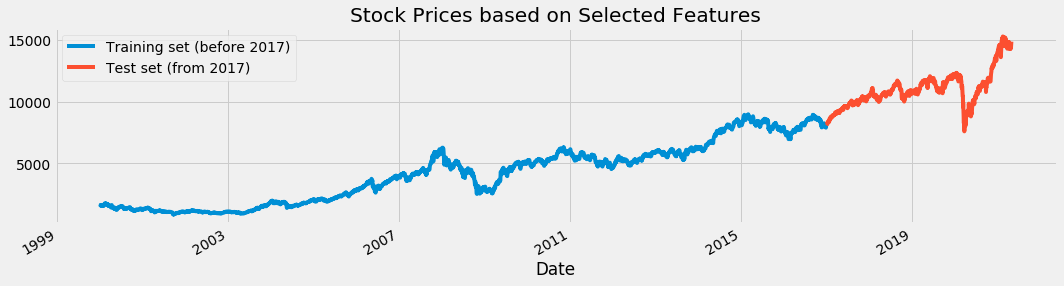

In [14]:
# Assuming 'Date' is not in datetime format, convert it to datetime
data.index = pd.to_datetime(data.index)

# Plotting the "Close" attribute based on the selected features
data['Close'].loc[:'2016-12-31'].plot(figsize=(16, 4), legend=True)
data['Close'].loc['2017-01-01':].plot(figsize=(16, 4), legend=True)
plt.legend(["Training set (before 2017)", "Test set (from 2017)"])
plt.title("Stock Prices based on Selected Features")
plt.xlabel("Date")
plt.show()




In [15]:
# Check the data types of the 'High' attribute
#print(data['Close'].dtype)

# If it's not already numeric, convert it to numeric
#data['Close'] = pd.to_numeric(data['H'], errors='coerce')

# Check the data types again
#print(data['High'].dtype)

# Now, you can proceed with the scaling
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)


In [16]:
# scaling the training set

#sc = MinMaxScaler(feature_range=(0,1))
#train_scaled = sc.fit_transform(train)

In [17]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements

x_train = []
y_train = []

for i in range(60, len(train_scaled)):
    x_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [18]:
x_train[0]

array([0.14437809, 0.13648284, 0.14049488, 0.13970351, 0.14331987,
       0.13219475, 0.14181996, 0.14119422, 0.14144268, 0.13939065,
       0.13848886, 0.14366954, 0.13745825, 0.14104699, 0.13975873,
       0.13475288, 0.13797355, 0.13709017, 0.12735454, 0.12796187,
       0.13504734, 0.13686932, 0.13720979, 0.14399161, 0.14880421,
       0.15375484, 0.15772087, 0.16596579, 0.16384935, 0.15612894,
       0.15770247, 0.16340765, 0.15893552, 0.16550569, 0.16284634,
       0.1549971 , 0.16154887, 0.15758284, 0.1598097 , 0.14734111,
       0.15799693, 0.15502471, 0.14756195, 0.1535432 , 0.15616574,
       0.14946675, 0.14576758, 0.13776191, 0.1300231 , 0.13119174,
       0.14095498, 0.13029915, 0.12926854, 0.13534181, 0.12867962,
       0.13165184, 0.13043718, 0.131477  , 0.1295722 , 0.12796187])

In [19]:
y_train[0]

0.1240878599100052

In [20]:
len(x_train)

1957

In [21]:
len(y_train)

1957

In [22]:
x_train.shape

(1957, 60)

In [23]:
y_train.shape

(1957,)

In [24]:
# reshaping x_train for efficient modelling

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [25]:
x_train.shape

(1957, 60, 1)

In [26]:
dataset_total = pd.concat((data[selected_features][:'2016'], data[selected_features]['2017':]), axis=0)
inputs = dataset_total[len(dataset_total)-len(test)-60 : ].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [27]:
# preparing x_test

x_test = []
for i in range(60,311):
    x_test.append(inputs[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [28]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

In [29]:
# compiling the model

regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')

# fitting the model

regressorGRU.fit(x_train, y_train, epochs=5, batch_size=150)

Epoch 1/5
1957/1957 [==============================] - 7s 4ms/step - loss: 0.0618
Epoch 2/5
1957/1957 [==============================] - 3s 1ms/step - loss: 0.0357
Epoch 3/5
1957/1957 [==============================] - 3s 1ms/step - loss: 0.0209
Epoch 4/5
1957/1957 [==============================] - 3s 1ms/step - loss: 0.0068
Epoch 5/5
1957/1957 [==============================] - 3s 2ms/step - loss: 0.0024


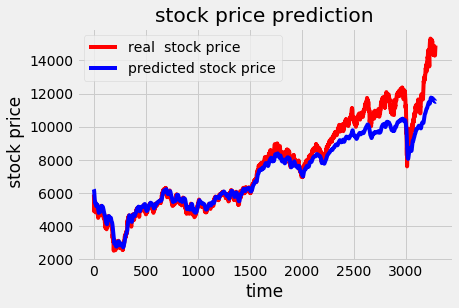

the root mean squared error is : 869.6887400779198.


In [30]:
# Assuming len(test) is the correct length of your test set
# Adjust the range accordingly to match the length of your test set
x_test = np.array([inputs[i-60:i, 0] for i in range(60, len(test) + 60)])

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predicting the stock prices for the test set
predicted_with_gru = regressorGRU.predict(x_test)
predicted_with_gru = sc.inverse_transform(predicted_with_gru)

# visualizing the results: predicted vs test
plot_predictions(test, predicted_with_gru)

# evaluating the model performance
return_rmse(test, predicted_with_gru)


In [31]:
# evaluating the model performance

return_rmse(test, predicted_with_gru)

the root mean squared error is : 869.6887400779198.


In [32]:
def return_rmse_percentage(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    percentage_rmse = (rmse / np.mean(test)) * 100  # Calculate RMSE percentage
    print("The Root Mean Squared Error (RMSE) in percentage is: {:.2f}%.".format(percentage_rmse))

# Call the return_rmse_percentage function with the test and predicted values
return_rmse_percentage(test, predicted_with_gru)


The Root Mean Squared Error (RMSE) in percentage is: 11.36%.
